# Plots for MS Thesis #

## Step 1: Preliminary Data Aggregation ##

This is where we use [Zooniverse Panoptes_Aggregation Docs](https://aggregation-caesar.zooniverse.org/docs) to aggregate, reduce, and analyze data classified by users on the *Name that Neutrino!* citizen science project. 

For my (Elizabeth's) thesis, I will be referring to this data as Phase 1/launch data. 

1. Go to project's "data exports" page and click all of the items you want to download. Note that "workflow classifications csv" no longer works. Check your email for a notice from Zooniverse that your data is ready to download. Download your data. 

2. Take note of the project's workflow ID number and workflow version. 
    1. Launch workflow ID: 23715.
    2. Major version: 2.
    3. Minor version (optional): 21.
    
3. In terminal, run the command `panoptes_aggregation config name-that-neutrino-workflows.csv 23715 -v 2.21` in location of downloaded csv files. This produces several files. 
    1. Make a new csv from `name-that-neutrino-classifications.csv` containing only the classifcations of the desired workflow and version. 

4. Extract the data we want for our desired workflow using the command `panoptes_aggregation extract name-that-neutrino-classifications.csv Extractor_config_workflow_23715_V2.21.yaml -o [date/name/whatever]`

5. Run question reducer (perhaps in the future, find a way to make a better reducer/extractor) using the command `panoptes_aggregation reduce question_extractor_05102023.csv Reducer_config_workflow_23715_V2.21_question_extractor.yaml -o [date/name/whatever]`
    1. If you want all classifications, use default question reduce config.
    2. If you want consensus classifications, change default question reducer config to question_consensus. 
    3. Note that there must be only one reducer in the config file. 

Now we can begin making the actual table that we use in analysis and making plots.

## Step 2: Make the Table ##

This table will contain consensus user classifications and the metadata from the manifest. 

In [1]:
#Import necessary packages

import pandas as pd
#from panoptes_aggregation.csv_utils import unjson_dataframe
import json #reading java strings into python dictionaries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#Pull out the columns from csv's made in step 1. 

# the `data.*` columns are read in as strings instead of arrays
data_consensus = pd.read_csv('question_consensus_reducer_05102023.csv')
ntn_subjects = pd.read_csv('name-that-neutrino-classifications.csv')


In [3]:
#initiate empty lists of keys wanted. 
runs = []
events = []
energies = []
zeniths = []
oneweights = []
pred_skims = []
pred_cascades = []
pred_tgtracks = []
pred_stoptracks = []
pred_starttracks = []
binned_log10Es = []
idx_max_scores = []
max_score_vals = []
pred_stoptracks = []
truth_classifications = []
subj_ids = []
total_class_counts = []


#go through the classifications csv
for i in range(len(ntn_subjects)):
    dict1 = json.loads(ntn_subjects['subject_data'][i]) #each event/subject id is its own dictionary in classifications csv. 
    for key in dict1.keys(): #get the keys for each event's dictionary
        if key in subj_ids: #if you already have the event saved, go to the next event. 
            continue
        subj_ids.append(key)  #add the event (key) to a list
        
        if dict1[key]['retired'] == None: #if the event is not retired, save to classification counts list as 0. 
            total_class_counts.append(0)
        else:
            total_class_counts.append(dict1[key]['retired']['classifications_count']) #if event is retired, save classification counts
            
        runs.append(dict1[key]['run']) #get the other desired keys and save as a list in order of appearence. 
        events.append(dict1[key]['event'])
        energies.append(dict1[key]['energy'])
        zeniths.append(dict1[key]['zenith'])
        oneweights.append(dict1[key]['oneweight'])
        pred_skims.append(dict1[key]['pred_skim'])
        pred_cascades.append(dict1[key]['pred_cascade'])
        pred_tgtracks.append(dict1[key]['pred_tgtrack'])
        pred_stoptracks.append(dict1[key]['pred_stoptrack'])
        pred_starttracks.append(dict1[key]['pred_starttrack'])
        binned_log10Es.append(dict1[key]['binned_log10E'])
        idx_max_scores.append(dict1[key]['idx_max_score'])
        max_score_vals.append(dict1[key]['max_score_val'])
        truth_classifications.append(dict1[key]['truth_classification'])

In [4]:
data = {'subject_id':subj_ids, 'total_class_count':total_class_counts,'run':runs,'event':events,'energy':energies,
        'zenith':zeniths,'oneweight':oneweights,'pred_skim':pred_skims,'pred_cascade':pred_cascades,
        'pred_tgtrack':pred_tgtracks,'pred_starttracks':pred_starttracks,'pred_stoptrack':pred_stoptracks,
        'binned_log10E':binned_log10Es,'idx_max_score':idx_max_scores,'max_score_val':max_score_vals,'truth_classification':truth_classifications
}

In [5]:
icecube_info = pd.DataFrame(data)

In [6]:
icecube_info_sorted = icecube_info.sort_values('subject_id')
icecube_info_sorted = icecube_info_sorted.reset_index()
icecube_info_sorted = icecube_info_sorted.drop(['index'],axis=1)

In [7]:
#Merge IceCube and User dataframes. 
result_consensus = pd.concat([data_consensus, icecube_info_sorted], axis=1) 
#for some reason subject id columns are repeated, unsure how to delete only one and not the other. 

Add in or rename columns in `result_consensus` dataframe. 

In [8]:
#Get all the event types to be in desired form
result_consensus = result_consensus.replace({'truth_classification':[1,2,3,4,5,6,7,8]},{'truth_classification':[2,3,4,0,4,1,1,1]},regex=False)

In [9]:
#Change how user labels appear
result_consensus = result_consensus.replace({'data.most_likely':['skimming-track','cascade','through-going-track','starting-track','stopping-track']},{'data.most_likely':[0,1,2,3,4]},regex=False)

In [10]:
#Change how ML labels appear
result_consensus = result_consensus.replace({'idx_max_score':['pred_skim','pred_cascade','pred_tgtrack','pred_starttrack','pred_stoptrack']},{'idx_max_score':[0,1,2,3,4]},regex=False)

In [11]:
#Check that the renaming all worked.
print(f'Length of Table: {len(result_consensus)}')
print(f'List of Columns in Table:{list(result_consensus.columns)}')
result_consensus.head()

Length of Table: 4273
List of Columns in Table:['subject_id', 'workflow_id', 'task', 'reducer', 'data.most_likely', 'data.num_votes', 'data.agreement', 'data.aggregation_version', 'subject_id', 'total_class_count', 'run', 'event', 'energy', 'zenith', 'oneweight', 'pred_skim', 'pred_cascade', 'pred_tgtrack', 'pred_starttracks', 'pred_stoptrack', 'binned_log10E', 'idx_max_score', 'max_score_val', 'truth_classification']


,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
0,86173828,23715,T0,question_consensus_reducer,0,6,0.400000,4.0.0,86173828,15,...,4.876933e+15,2.697562e-07,5.884553e-06,7.236299e-07,0.999993,1.275522e-08,22,3,0.999993,3
1,86173829,23715,T0,question_consensus_reducer,3,6,0.400000,4.0.0,86173829,15,...,2.663341e+13,2.834930e-04,1.535801e-05,8.349076e-02,0.001865,9.143454e-01,15,4,0.914345,4
2,86173832,23715,T0,question_consensus_reducer,2,5,0.333333,4.0.0,86173832,15,...,7.751700e+13,4.526310e-02,2.889185e-02,8.148136e-01,0.071845,3.918632e-02,18,2,0.814814,2
3,86173836,23715,T0,question_consensus_reducer,0,6,0.400000,4.0.0,86173836,15,...,3.099100e+14,1.084101e-03,3.105337e-04,9.978841e-01,0.000281,4.407210e-04,19,2,0.997884,2
4,86173842,23715,T0,question_consensus_reducer,1,8,0.533333,4.0.0,86173842,15,...,4.451944e+16,9.977952e-01,2.037910e-08,2.137906e-03,0.000005,6.144758e-05,24,0,0.997795,0


## Step 3: Cuts on Table ##

Unfiltered Table: `result_consensus`

Filtered Table 1: `result_retired_user55`
- Data agreement 55% or greater.
- Minimum 15 classifications per event. 

Filtered Table 2: `result_retired`
- Minimum 15 classificaitons per event. 

Make the desired cuts on the table. In this notebook I will cut on:
* Events with 15 classifications (retirement limit).
* A consensus between users of 55% or higher. 

In [12]:
result_retired_user55 = result_consensus[(result_consensus['total_class_count']>14.0) & (result_consensus['data.agreement']>=0.55)]

In [13]:
print(f'Length of Table: {len(result_retired_user55)}')
print(f'List of Columns in Table:{list(result_retired_user55.columns)}')
result_retired_user55.head()

Length of Table: 1244
List of Columns in Table:['subject_id', 'workflow_id', 'task', 'reducer', 'data.most_likely', 'data.num_votes', 'data.agreement', 'data.aggregation_version', 'subject_id', 'total_class_count', 'run', 'event', 'energy', 'zenith', 'oneweight', 'pred_skim', 'pred_cascade', 'pred_tgtrack', 'pred_starttracks', 'pred_stoptrack', 'binned_log10E', 'idx_max_score', 'max_score_val', 'truth_classification']


,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
8,86173870,23715,T0,question_consensus_reducer,0,10,0.666667,4.0.0,86173870,15,...,5.257484e+13,0.189478,0.566502,0.005127,0.236380,0.002514,18,1,0.566502,3
12,86173885,23715,T0,question_consensus_reducer,2,9,0.600000,4.0.0,86173885,15,...,1.749646e+07,0.233075,0.088348,0.590476,0.036485,0.051616,1,2,0.590476,0
15,86173897,23715,T0,question_consensus_reducer,0,11,0.733333,4.0.0,86173897,15,...,7.818481e+09,0.705922,0.003039,0.217608,0.032069,0.041362,8,0,0.705922,0
18,86173910,23715,T0,question_consensus_reducer,2,10,0.625000,4.0.0,86173910,16,...,4.187937e+13,0.052838,0.016143,0.901687,0.013350,0.015982,15,2,0.901687,0
19,86173914,23715,T0,question_consensus_reducer,0,13,0.866667,4.0.0,86173914,15,...,1.926450e+08,0.568451,0.047416,0.243443,0.029045,0.111644,3,0,0.568451,0


In [14]:
result_retired = result_consensus[result_consensus['total_class_count']>14]

In [15]:
print(f'Length of Table: {len(result_retired)}')
print(f'List of Columns in Table:{list(result_retired.columns)}')
result_retired.head()

Length of Table: 4273
List of Columns in Table:['subject_id', 'workflow_id', 'task', 'reducer', 'data.most_likely', 'data.num_votes', 'data.agreement', 'data.aggregation_version', 'subject_id', 'total_class_count', 'run', 'event', 'energy', 'zenith', 'oneweight', 'pred_skim', 'pred_cascade', 'pred_tgtrack', 'pred_starttracks', 'pred_stoptrack', 'binned_log10E', 'idx_max_score', 'max_score_val', 'truth_classification']


,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
0,86173828,23715,T0,question_consensus_reducer,0,6,0.400000,4.0.0,86173828,15,...,4.876933e+15,2.697562e-07,5.884553e-06,7.236299e-07,0.999993,1.275522e-08,22,3,0.999993,3
1,86173829,23715,T0,question_consensus_reducer,3,6,0.400000,4.0.0,86173829,15,...,2.663341e+13,2.834930e-04,1.535801e-05,8.349076e-02,0.001865,9.143454e-01,15,4,0.914345,4
2,86173832,23715,T0,question_consensus_reducer,2,5,0.333333,4.0.0,86173832,15,...,7.751700e+13,4.526310e-02,2.889185e-02,8.148136e-01,0.071845,3.918632e-02,18,2,0.814814,2
3,86173836,23715,T0,question_consensus_reducer,0,6,0.400000,4.0.0,86173836,15,...,3.099100e+14,1.084101e-03,3.105337e-04,9.978841e-01,0.000281,4.407210e-04,19,2,0.997884,2
4,86173842,23715,T0,question_consensus_reducer,1,8,0.533333,4.0.0,86173842,15,...,4.451944e+16,9.977952e-01,2.037910e-08,2.137906e-03,0.000005,6.144758e-05,24,0,0.997795,0


In [16]:
result_retired['total_class_count'].value_counts()

15    4073
16      98
20      34
19      25
21      20
18       8
22       8
24       3
17       2
23       2
Name: total_class_count, dtype: int64

In [175]:
result_retired['max_score_val'].value_counts()

1.000000    9
1.000000    8
1.000000    5
0.999995    4
0.999998    4
           ..
0.997522    1
0.921155    1
0.998250    1
0.751667    1
0.585382    1
Name: max_score_val, Length: 4188, dtype: int64

In [ ]:
result_retired['data.agreement'].value_counts()

In [18]:
result_evendistrib = result_retired[result_retired['data.agreement']<=0.2]
result_evendistrib

,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
10,86173877,23715,T0,question_consensus_reducer,1,3,0.2,4.0.0,86173877,15,...,4.441833e+10,0.584260,0.003852,0.163106,0.072116,0.176666,9,0,0.584260,2
3099,86869964,23715,T0,question_consensus_reducer,0,3,0.2,4.0.0,86869964,15,...,5.344921e+07,0.515057,0.126537,0.146868,0.087308,0.124230,3,0,0.515057,0


In [45]:
result_retired[1925:1926]

,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
1925,86793028,23715,T0,question_consensus_reducer,1,6,0.4,4.0.0,86793028,15,...,9.235697e+13,0.000025,0.950276,0.000011,0.049678,0.00001,19,1,0.950276,1


In [44]:
result_retired[1986:1987]

,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
1986,86793544,23715,T0,question_consensus_reducer,1,8,0.533333,4.0.0,86793544,15,...,2.008010e+14,0.999995,3.372042e-10,1.346272e-07,2.345776e-07,0.000005,20,0,0.999995,1


In [253]:
result_usermoreconf = result_retired[result_retired['data.agreement']>result_retired['max_score_val']]

In [256]:
result_usermoreconf.sort_values(['data.agreement'])

,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
3656,86916225,23715,T0,question_consensus_reducer,4,5,0.333333,4.0.0,86916225,15,...,3.967583e+09,0.264097,6.026193e-02,0.120416,0.255471,0.299753,8,4,0.299753,1
2850,86851631,23715,T0,question_consensus_reducer,2,5,0.333333,4.0.0,86851631,15,...,1.333084e+07,0.257685,7.618977e-02,0.097303,0.314033,0.254789,1,3,0.314033,0
3153,86870018,23715,T0,question_consensus_reducer,1,5,0.333333,4.0.0,86870018,15,...,1.363284e+11,0.312556,1.064521e-01,0.317523,0.046900,0.216570,10,2,0.317523,0
1291,86176764,23715,T0,question_consensus_reducer,4,5,0.333333,4.0.0,86176764,15,...,1.423255e+08,0.282909,1.735721e-01,0.308146,0.102670,0.132703,4,2,0.308146,1
2423,86811398,23715,T0,question_consensus_reducer,2,5,0.333333,4.0.0,86811398,15,...,1.536644e+07,0.303938,9.016915e-02,0.249432,0.032805,0.323655,1,4,0.323655,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,86175794,23715,T0,question_consensus_reducer,0,13,0.866667,4.0.0,86175794,15,...,1.451420e+16,0.734156,3.807446e-07,0.265602,0.000002,0.000240,25,0,0.734156,0
1118,86176591,23715,T0,question_consensus_reducer,0,14,0.933333,4.0.0,86176591,15,...,4.142114e+06,0.311440,2.217693e-03,0.533267,0.004018,0.149056,1,2,0.533267,1
131,86174454,23715,T0,question_consensus_reducer,0,14,0.933333,4.0.0,86174454,15,...,9.977341e+08,0.114633,5.456023e-02,0.695728,0.021419,0.113660,5,2,0.695728,0
964,86176337,23715,T0,question_consensus_reducer,0,14,0.933333,4.0.0,86176337,15,...,3.246604e+16,0.865564,4.181250e-07,0.121997,0.000191,0.012246,23,0,0.865564,0


In [276]:
result_usermoreconf[result_usermoreconf['data.agreement']>=0.88]

,subject_id,workflow_id,task,reducer,data.most_likely,data.num_votes,data.agreement,data.aggregation_version,subject_id,total_class_count,...,oneweight,pred_skim,pred_cascade,pred_tgtrack,pred_starttracks,pred_stoptrack,binned_log10E,idx_max_score,max_score_val,truth_classification
131,86174454,23715,T0,question_consensus_reducer,0,14,0.933333,4.0.0,86174454,15,...,9.977341e+08,0.114633,5.456023e-02,0.695728,0.021419,0.113660,5,2,0.695728,0
357,86175460,23715,T0,question_consensus_reducer,0,15,1.000000,4.0.0,86175460,15,...,5.968416e+08,0.267378,5.978687e-02,0.067031,0.032268,0.573536,4,4,0.573536,0
964,86176337,23715,T0,question_consensus_reducer,0,14,0.933333,4.0.0,86176337,15,...,3.246604e+16,0.865564,4.181250e-07,0.121997,0.000191,0.012246,23,0,0.865564,0
1118,86176591,23715,T0,question_consensus_reducer,0,14,0.933333,4.0.0,86176591,15,...,4.142114e+06,0.311440,2.217693e-03,0.533267,0.004018,0.149056,1,2,0.533267,1


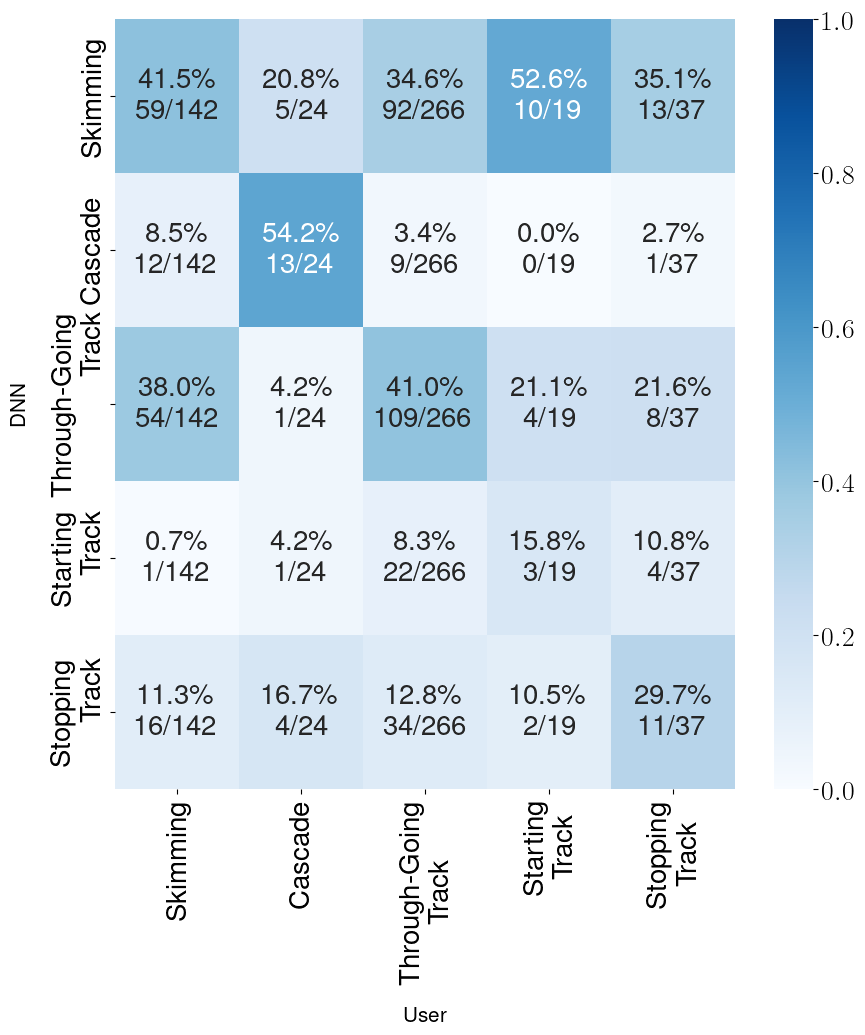

In [255]:
confusion_matrix_userconf_norm = pd.crosstab(result_usermoreconf['idx_max_score'], result_usermoreconf['data.most_likely'], rownames=['dnn'], colnames=['user'], margins=False,normalize='columns')
confusion_matrix_userconf = pd.crosstab(result_usermoreconf['idx_max_score'], result_usermoreconf['data.most_likely'], rownames=['dnn'], colnames=['user'], margins=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix_userconf_norm, annot=GetUncertaintyLabels(confusion_matrix_userconf), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0)
plt.ylabel('DNN',fontsize=15,labelpad=15)
plt.xlabel('User',fontsize=15,labelpad=15)
#plt.savefig("ml_user_cm_cut.png")
plt.show()

## Step 4: Plots ##

For `result_retired`, making the plots:
- Histogram of consensus score. 
- Energy vs. consensus score. 
- 2D histogram of user vs. ML score. 

For `result_retired_user55`, making the plots: 
- Confusion matrix with truth classificaiton, normalized on truth. 
- Confusion matrix with ML and user classifications, normalized on user. 

### Results Retired ###

In [123]:
#Get the possible value of the consensus voter fractions
x = result_retired['data.agreement'].value_counts(ascending=False).keys().tolist() #use for tick marks. 

In [124]:
xtick_labels = []
for i in np.arange(0,len(bin_edges)):
    xtick_labels.append("{:0.2f}".format(bin_edges[i]))

In [125]:
#Need to specify bin edges so that the scores are centered in the bins
bin_edges = np.histogram_bin_edges(result_retired['data.agreement'][:],bins=13,range= (1/6,15.5/15))

In [126]:
np.digitize(result_retired['data.agreement'], bin_edges, right=True)

array([4, 4, 3, ..., 3, 6, 3])

In [149]:
new_bin_labels = np.arange(2/15,16/15,1/15).round(2)
print(len(new_bin_labels))

14


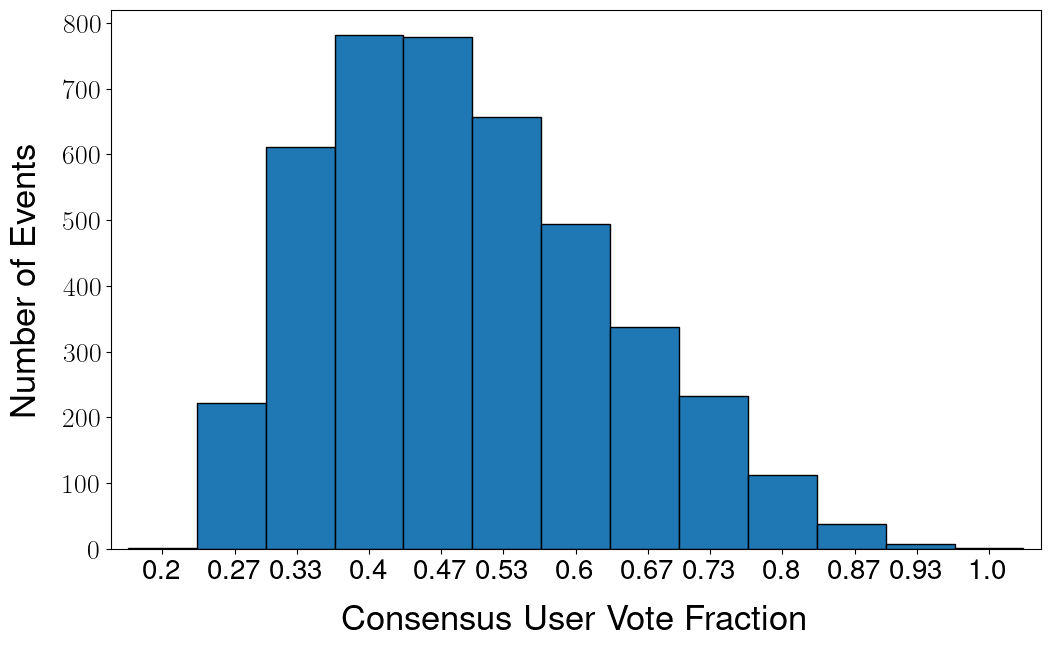

In [182]:
#Histogram of Max User Scores

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 20
})


result_retired['data.agreement'].plot(kind='hist',bins=bin_edges,logy=False,edgecolor='black',figsize=(12,7))
#plt.axvline(x = 0.55, color = 'r', label = 'axvline - full height')
#plt.axvline(x = 0.533333, color = 'r', label = 'axvline - full height')

plt.xlabel(r'Consensus User Vote Fraction',fontsize=25,labelpad=15)
plt.ylabel(r'Number of Events',fontsize=25,labelpad=15)
#plt.annotate('Cut at 55% and Greater',xy=(0.6,700),xytext=(0.8,700),arrowprops=dict(facecolor="r"))

#bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="r", ec="r", lw=2)
#t = plt.text(0.57,700, "Cut at 55%", ha="left", va="center", rotation=0,
           # size=10,
           # bbox=bbox_props)

#bb = t.get_bbox_patch()
#bb.set_boxstyle("rarrow", pad=0.6)

plt.xticks(new_bin_labels,labels=new_bin_labels,rotation=0,fontsize=20)
plt.xlim(0.15,1.05)
#plt.title('Distribution of Max User Score')
plt.show()

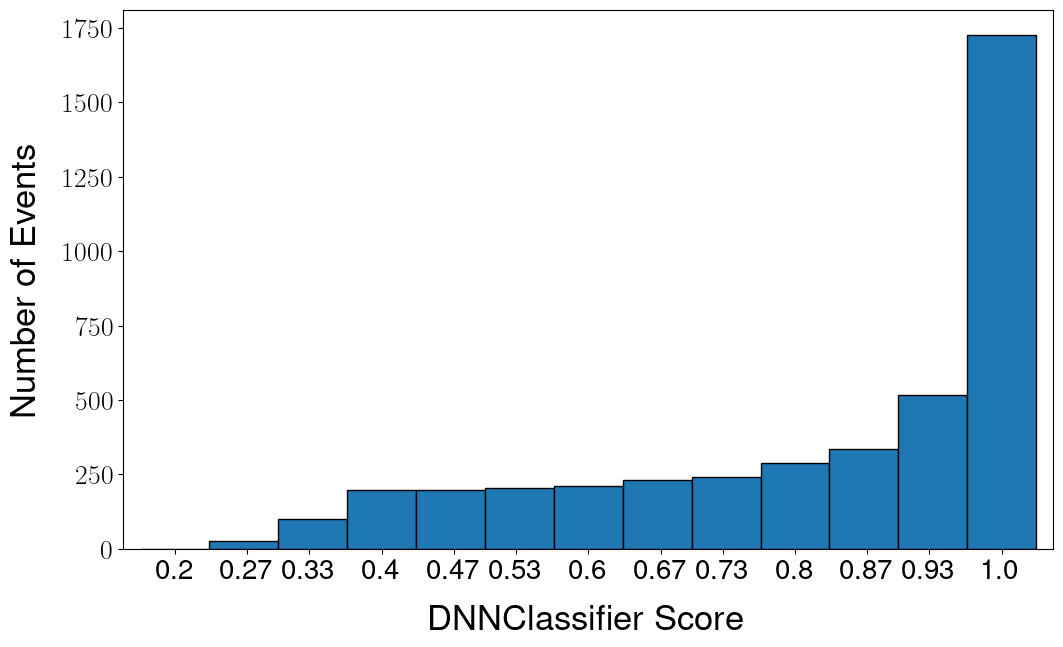

In [183]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size":20
})

result_retired['max_score_val'].plot(kind='hist',bins=bin_edges,logy=False,edgecolor='black',figsize=(12,7))
#plt.axvline(x = 0.55, color = 'r', label = 'axvline - full height')
#plt.axvline(x = 0.533333, color = 'r', label = 'axvline - full height')

plt.xlabel(r'DNNClassifier Score',fontsize=25,labelpad=15)
plt.ylabel('Number of Events',fontsize=25,labelpad=15)
#plt.annotate('Cut at 55% and Greater',xy=(0.6,700),xytext=(0.8,700),arrowprops=dict(facecolor="r"))

#bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="r", ec="r", lw=2)
#t = plt.text(0.57,700, "Cut at 55%", ha="left", va="center", rotation=0,
           # size=10,
           # bbox=bbox_props)

#bb = t.get_bbox_patch()
#bb.set_boxstyle("rarrow", pad=0.6)

plt.xticks(new_bin_labels,labels=new_bin_labels,rotation=0,fontsize=20)
plt.xlim(0.15,1.05)
#plt.title('Distribution of Max User Score')
plt.show()

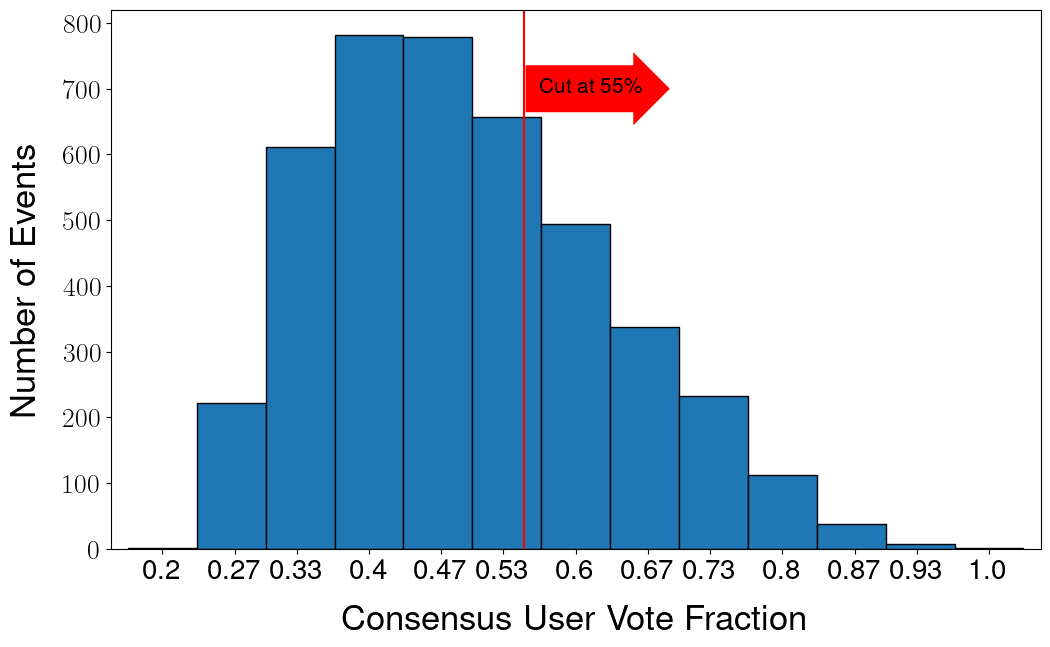

In [277]:
#Histogram of Max User Scores

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size":20
})

result_retired['data.agreement'].plot(kind='hist',bins=bin_edges,logy=False,edgecolor='black',figsize=(12,7))
plt.axvline(x = 0.55, color = 'r', label = 'axvline - full height')
#plt.axvline(x = 0.533333, color = 'r', label = 'axvline - full height')

plt.xlabel(r'Consensus User Vote Fraction',labelpad=15,fontsize=25)
plt.ylabel('Number of Events',labelpad=15,fontsize=25)
#plt.annotate('Cut at 55% and Greater',xy=(0.6,700),xytext=(0.8,700),arrowprops=dict(facecolor="r"))

bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="r", ec="r", lw=2)
t = plt.text(0.565,700, r"Cut at 55\%", ha="left", va="center", rotation=0,
            size=15,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("rarrow", pad=0.6)

plt.xticks(new_bin_labels,labels=new_bin_labels,rotation=0,fontsize=20)
plt.xlim(0.15,1.05)

#plt.title('Distribution of Max User Score')
plt.show()

In [143]:
result_retired['data.agreement'].value_counts(ascending=False)

0.466667    749
0.400000    740
0.533333    595
0.333333    583
0.600000    475
           ... 
0.450000      1
0.380952      1
0.842105      1
0.304348      1
0.714286      1
Name: data.agreement, Length: 61, dtype: int64

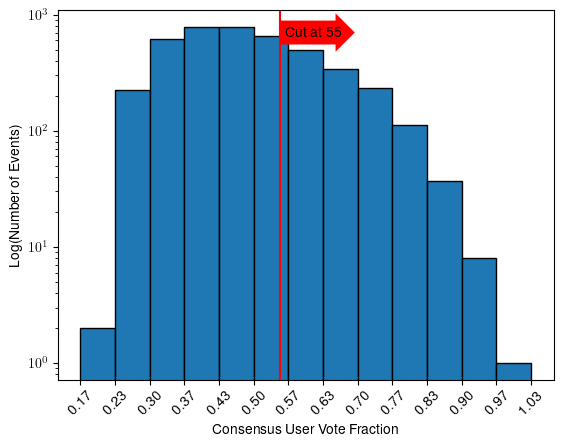

In [30]:
#Histogram of Max User Scores (log y scale)
result_retired['data.agreement'].plot(kind='hist',bins=bin_edges,logy=True,edgecolor='black')
plt.axvline(x = 0.55, color = 'r', label = 'axvline - full height')
plt.xlabel('Consensus User Vote Fraction')
plt.ylabel('Log(Number of Events)')
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="r", ec="r", lw=2)
plt.text(0.56,700, "Cut at 55%", ha="left", va="center", rotation=0,
            size=10,
            bbox=bbox_props)

bb = t.get_bbox_patch()
bb.set_boxstyle("rarrow", pad=0.6)
plt.xticks(bin_edges,labels=xtick_labels,rotation=45)

#plt.title('Distribution of Max User Score, Log Scale Y Axis')
#plt.xticks(x, rotation=45)
plt.show()

In [185]:
bin_edges_energy = np.histogram_bin_edges(np.log10(result_retired['energy'][:]),bins=13)

In [186]:
H, xedges, yedges = np.histogram2d(x=result_retired['data.agreement'],y=np.log10(result_retired['energy']),bins=(bin_edges,bin_edges_energy))

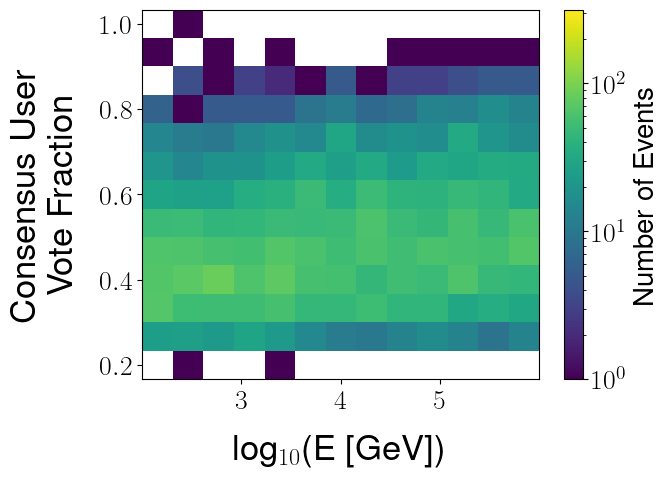

In [190]:
#plt.hist2d(result_retired['data.agreement'],result_retired['energy'],norm=mpl.colors.LogNorm(),bins=[xedges,yedges])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size":20
})

plt.hist2d(np.log10(result_retired['energy']),result_retired['data.agreement'],norm=mpl.colors.LogNorm(),bins=[yedges,xedges])
plt.colorbar(label=r'Number of Events')
plt.clim(10**0,10**2.5)
plt.xlabel(r'log$_{10}$(E [GeV])',fontsize=25,labelpad=15)
plt.ylabel("Consensus User\n Vote Fraction",fontsize=25,labelpad=15)
#plt.xticks(x,rotation=45)
plt.show()

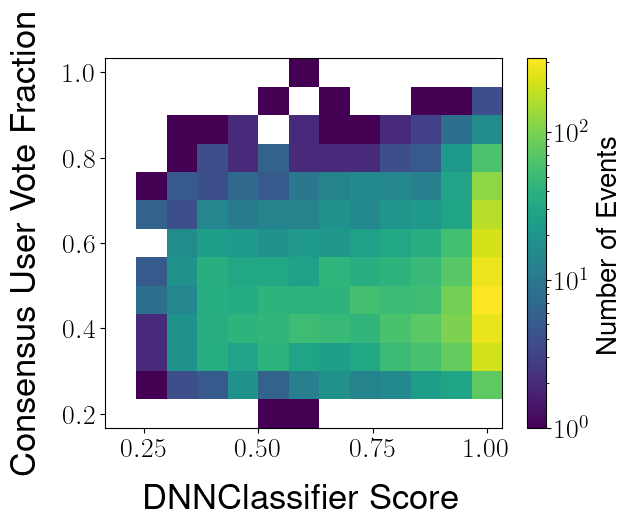

In [191]:
#plt.hist2d(result_retired['data.agreement'],result_retired['energy'],norm=mpl.colors.LogNorm(),bins=[xedges,yedges])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size":20
})

plt.hist2d(result_retired['max_score_val'],result_retired['data.agreement'],norm=mpl.colors.LogNorm(),bins=[xedges,xedges])
plt.colorbar(label=r'Number of Events')
plt.clim(10**0,10**2.5)
plt.xlabel("DNNClassifier Score",fontsize=25,labelpad=15)
plt.ylabel("Consensus User Vote Fraction",fontsize=25,labelpad=15)
#plt.xticks(x,rotation=45)
plt.show()

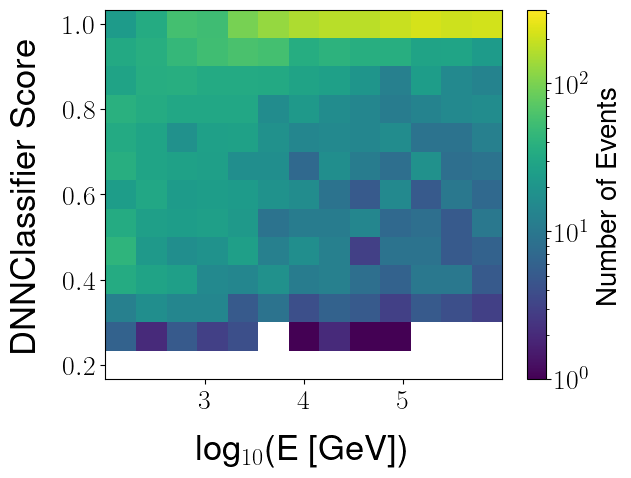

In [193]:
#plt.hist2d(result_retired['data.agreement'],result_retired['energy'],norm=mpl.colors.LogNorm(),bins=[xedges,yedges])
H, xedges, yedges = np.histogram2d(x=result_retired['max_score_val'],y=np.log10(result_retired['energy']),bins=(bin_edges,bin_edges_energy))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size":20
})

plt.hist2d(np.log10(result_retired['energy']),result_retired['max_score_val'],norm=mpl.colors.LogNorm(),bins=[yedges,xedges])
plt.colorbar(label=r'Number of Events')
plt.clim(10**0,10**2.5)
plt.xlabel(r'log$_{10}$(E [GeV])',fontsize=25,labelpad=15)
plt.ylabel("DNNClassifier Score",fontsize=25,labelpad=15)
#plt.xticks(x,rotation=45)
plt.show()

In [230]:
types = ['Skimming','Cascade','Through-Going\nTrack','Starting\nTrack','Stopping\nTrack']

In [213]:
def GetUncertaintyLabels(matrix_df):
    labels = []
    #pm=str(u"\u00B1")
    #normalized = []
    nrows, ncols = matrix_df.shape
    for i in range(0,nrows):
        col_sum = matrix_df.iloc[:,i].sum()
        for k in range(0,ncols):
            val = matrix_df.iloc[k,i]
            n_val = (val/col_sum.astype(float))*100
            val_percent_round = "%.1f" % n_val
            #er = np.sqrt(val)
            #er_round = "%.2f" % er
            lab_n = '%.1f%%'%n_val
            lab_v = '%d/%d'%(val,col_sum)
            lab='%.1f\%%\n%d/%d' % (n_val, val, col_sum)
            #print(str(lab))
            labelc= str(lab_n)+"\n"+str(lab_v)
            label = f"{str(lab_n)} {str(lab_v)}"
            #print(type(label))
            #print(label)           
            #print(str(label))
            labels.append(str(lab))
            #n_er = er/col_sum #want error to be a percent of the whole column, not of the count number--> why you div by col sum
            #perc_norm_val = '{:.2%}'.format(n_val)
            #perc_norm_er_round = '{:.2%}'.format(n_er)
            #normalize = str(perc_norm_val)+pm+str(perc_norm_er_round)
            #normalized.append(normalize)

    #print(labels)
    labels_array = np.asarray(labels)
    #print(labels_array)
    #normalized_array = np.asarray(normalized)
    labels_val = labels_array.reshape(5,5)
    labels_new = labels_val.T
    #normalized_err = normalized_array.reshape(5,5)
    #normalized_labels = normalized_err.T
    
    return labels_new

GetUncertaintyLabels(confusion_matrix_retired)

array([['37.2\\%\n306/822', '29.5\\%\n608/2062', '21.0\\%\n201/958',
        '19.9\\%\n65/327', '19.2\\%\n20/104'],
       ['9.0\\%\n74/822', '34.9\\%\n720/2062', '6.2\\%\n59/958',
        '30.3\\%\n99/327', '4.8\\%\n5/104'],
       ['38.1\\%\n313/822', '21.7\\%\n447/2062', '60.9\\%\n583/958',
        '24.8\\%\n81/327', '28.8\\%\n30/104'],
       ['4.1\\%\n34/822', '4.3\\%\n88/2062', '4.4\\%\n42/958',
        '16.2\\%\n53/327', '11.5\\%\n12/104'],
       ['11.6\\%\n95/822', '9.7\\%\n199/2062', '7.6\\%\n73/958',
        '8.9\\%\n29/327', '35.6\\%\n37/104']], dtype='<U15')

In [ ]:
confusion_matrix_user_ml_55_norm = pd.crosstab(result_retired_user55['data.most_likely'], result_retired_user55['idx_max_score'], rownames=['User'], colnames=['ML'], margins=False,normalize='columns')
confusion_matrix_user_ml_55 = pd.crosstab(result_retired_user55['data.most_likely'], result_retired_user55['idx_max_score'], rownames=['User'], colnames=['ML'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_user_ml_55_norm, annot=GetUncertaintyLabels(confusion_matrix_user_ml_55), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Percent'})
plt.ylabel('User Predicted Cut',fontsize=25,labelpad=15)
plt.xlabel('DNNClassifier Predicted Cut',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("ml_user_cm_cut.png")
plt.show()

BIGBIGBIG issue with using latex stuff in plots for labels of CM

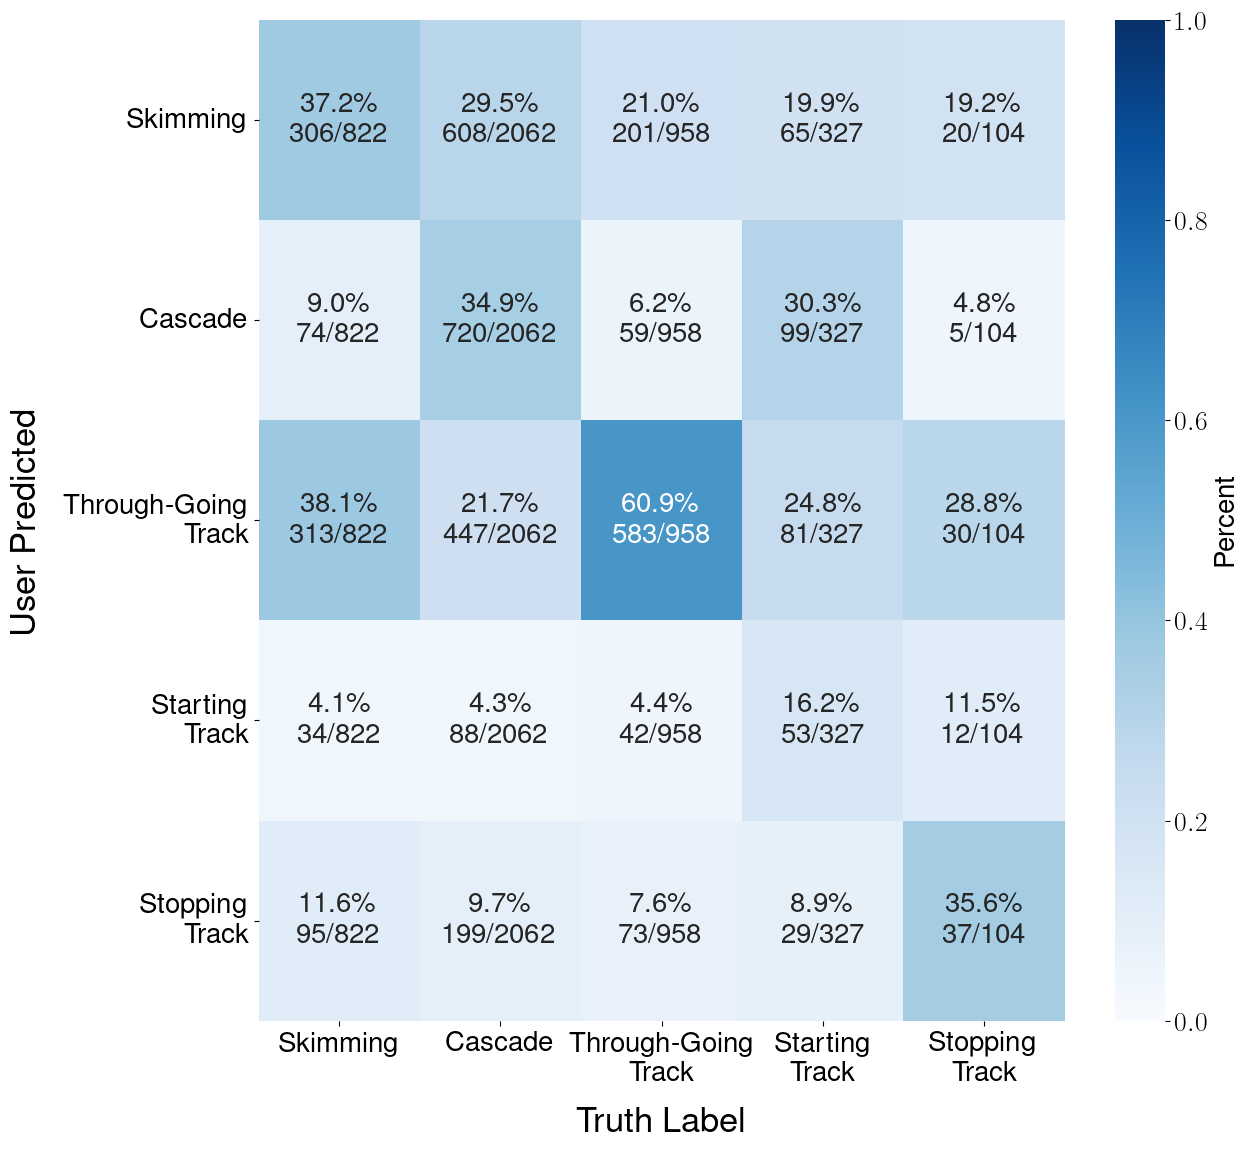

In [278]:
confusion_matrix_retired_norm = pd.crosstab(result_retired['data.most_likely'], result_retired['truth_classification'], rownames=['User Predicted'], colnames=['Truth'], margins=False,normalize='columns')
confusion_matrix_retired = pd.crosstab(result_retired['data.most_likely'], result_retired['truth_classification'], rownames=['User Predicted'], colnames=['Truth'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_retired_norm, annot=GetUncertaintyLabels(confusion_matrix_retired),fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label': 'Percent'})
plt.ylabel('User Predicted',fontsize=25,labelpad=15)
plt.xlabel('Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("user_retired_cm.png")
plt.show()

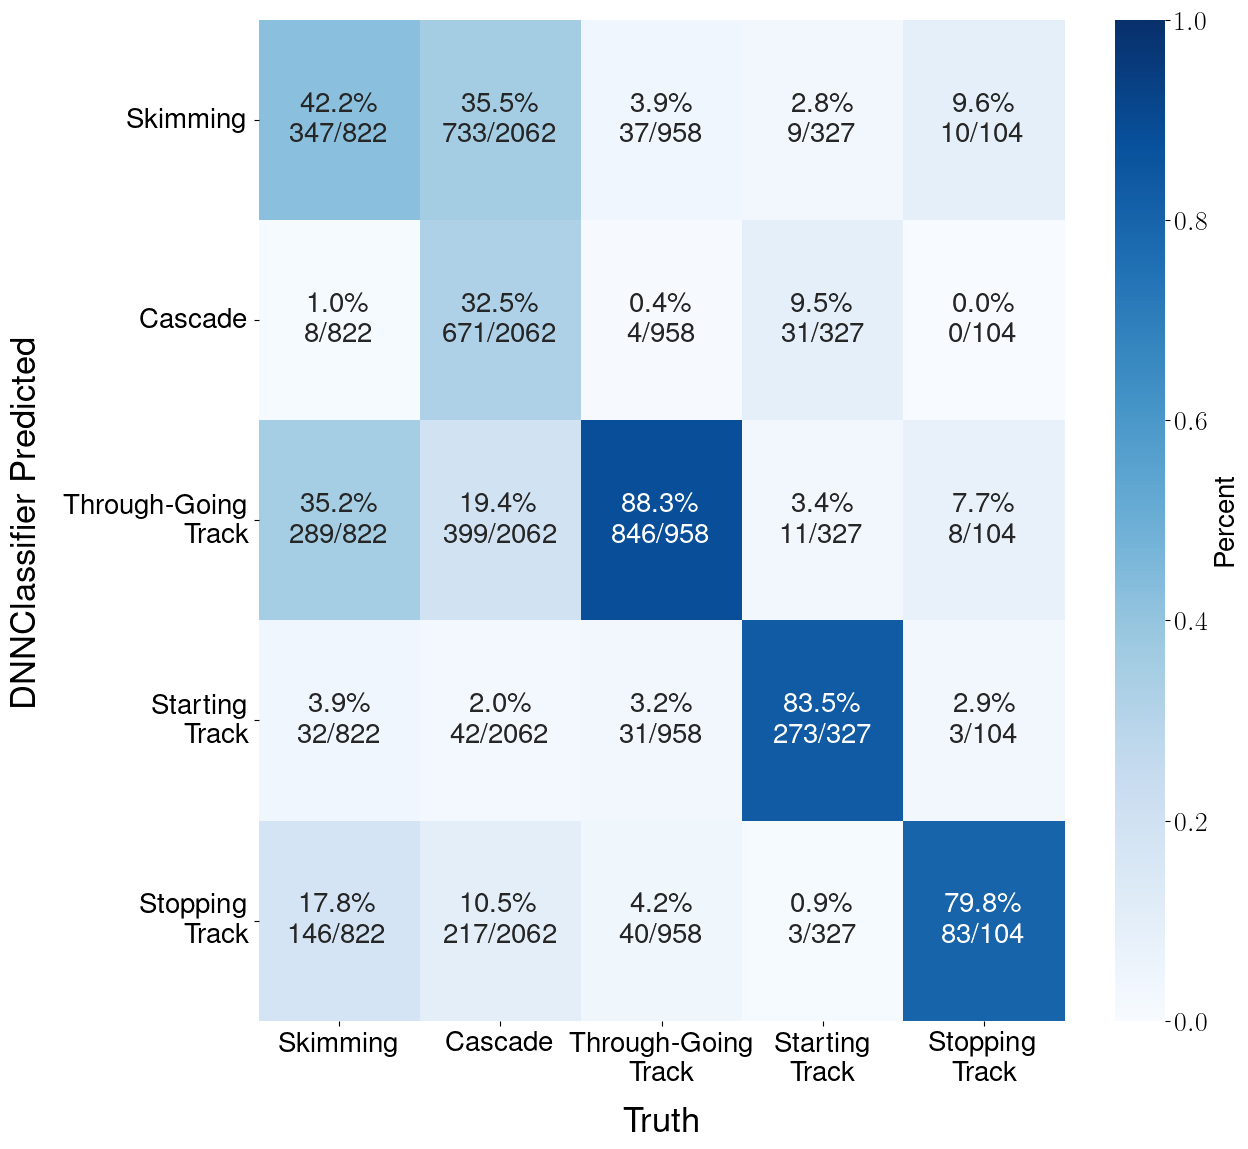

In [286]:
confusion_matrix_retired_ml_norm = pd.crosstab(result_retired['idx_max_score'], result_retired['truth_classification'], rownames=['ML Predicted'], colnames=['Truth'], margins=False,normalize='columns')
confusion_matrix_retired_ml = pd.crosstab(result_retired['idx_max_score'], result_retired['truth_classification'], rownames=['ML Predicted'], colnames=['Truth'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_retired_ml_norm, annot=GetUncertaintyLabels(confusion_matrix_retired_ml), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Percent'})
plt.ylabel('DNNClassifier Predicted',fontsize=25,labelpad=15)
plt.xlabel('Truth',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("ml_retired_cm.png")
plt.show()

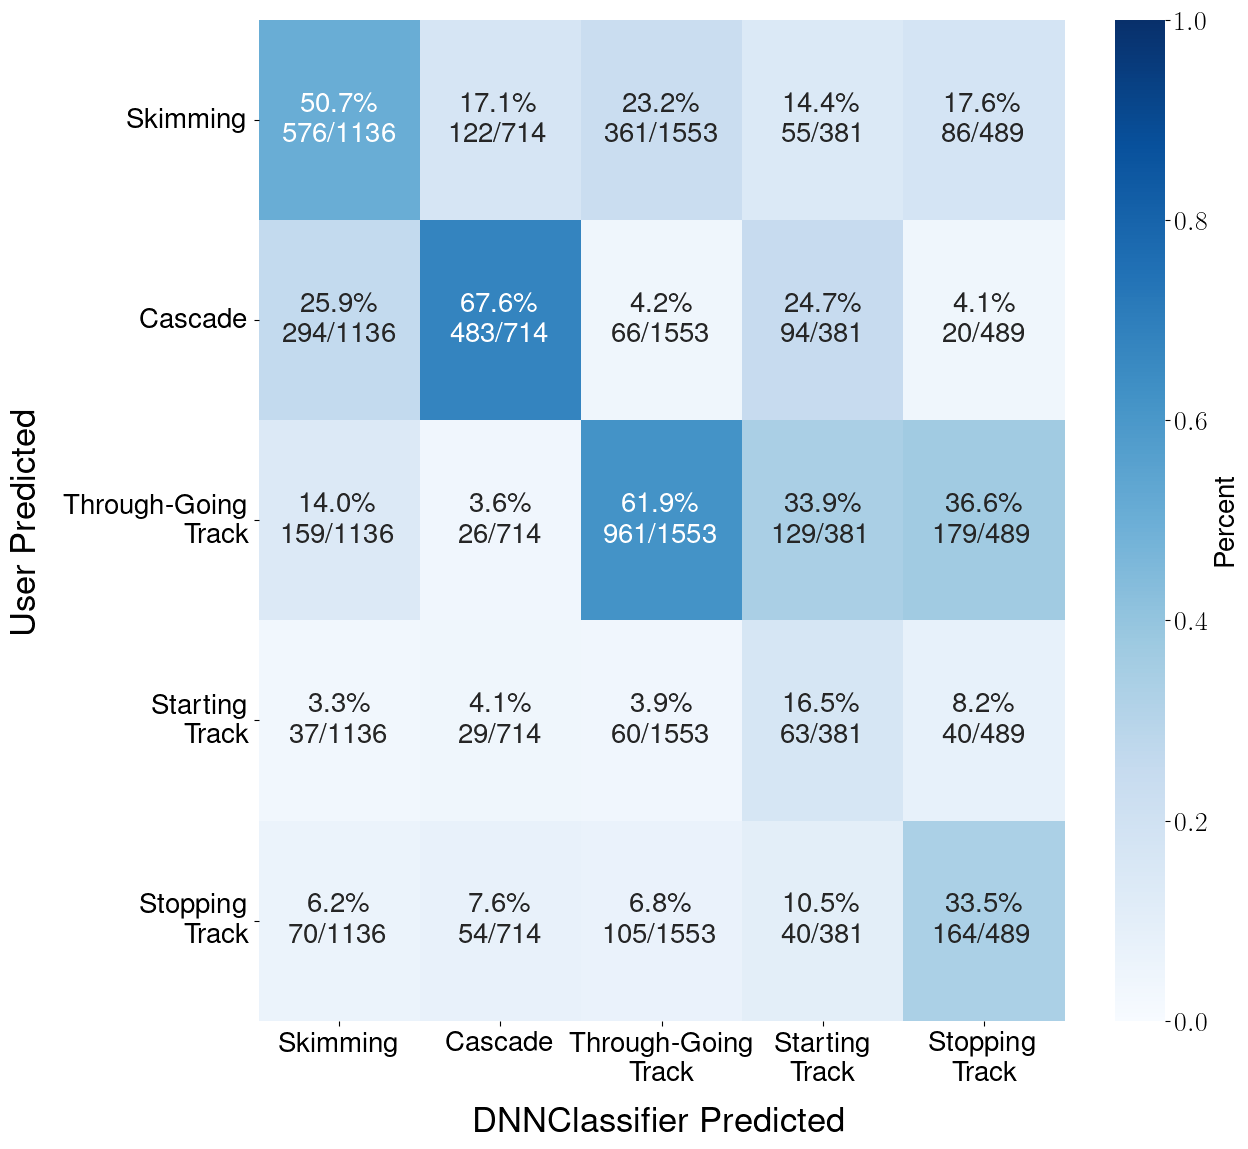

In [287]:
confusion_matrix_user_ml_norm = pd.crosstab(result_retired['data.most_likely'], result_retired['idx_max_score'], rownames=['User'], colnames=['ML'], margins=False,normalize='columns')
confusion_matrix_user_ml = pd.crosstab(result_retired['data.most_likely'], result_retired['idx_max_score'], rownames=['User'], colnames=['ML'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_user_ml_norm, annot=GetUncertaintyLabels(confusion_matrix_user_ml), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Percent'})
plt.ylabel('User Predicted',fontsize=25,labelpad=15)
plt.xlabel('DNNClassifier Predicted',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("ml_user_cm.png")
plt.show()


### Results Retired User Agreement 55% or Higher ###

In [158]:
#Get the possible value of the consensus voter fractions
x_55 = result_retired_user55['data.agreement'].value_counts(ascending=False).keys().tolist() #use for tick marks. 

In [159]:
#Need to specify bin edges so that the scores are centered in the bins
bin_edges_55 = np.histogram_bin_edges(result_retired_user55['data.agreement'][:],bins=13,range= (1/6,15.5/15))

In [161]:
bin_edges_55

array([0.16666667, 0.23333333, 0.3       , 0.36666667, 0.43333333,
       0.5       , 0.56666667, 0.63333333, 0.7       , 0.76666667,
       0.83333333, 0.9       , 0.96666667, 1.03333333])

In [162]:
x_55

[0.6,
 0.6666666666666666,
 0.7333333333333333,
 0.8,
 0.8666666666666667,
 0.5625,
 0.625,
 0.75,
 0.6875,
 0.9333333333333332,
 0.55,
 0.8125,
 0.65,
 0.631578947368421,
 0.6190476190476191,
 0.7,
 0.5714285714285714,
 0.7619047619047619,
 0.7272727272727273,
 0.6363636363636364,
 0.7083333333333334,
 0.9411764705882352,
 0.5555555555555556,
 0.8421052631578947,
 0.875,
 1.0,
 0.7142857142857143]

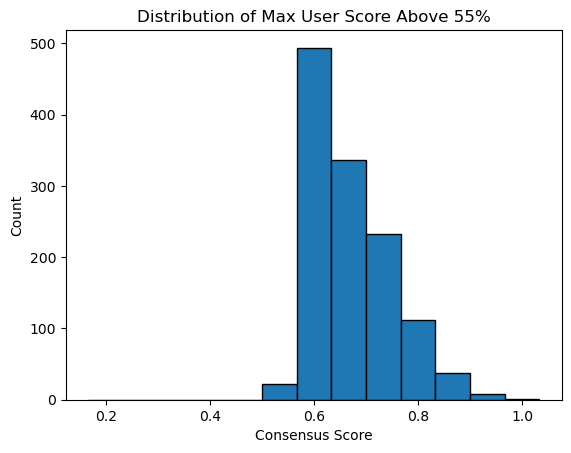

In [119]:
#Histogram of Max User Scores
result_retired_user55['data.agreement'].plot(kind='hist',bins=bin_edges_55,logy=False,edgecolor='black')
plt.xlabel('Consensus Score')
plt.ylabel('Count')
plt.title('Distribution of Max User Score Above 55%')
plt.show()

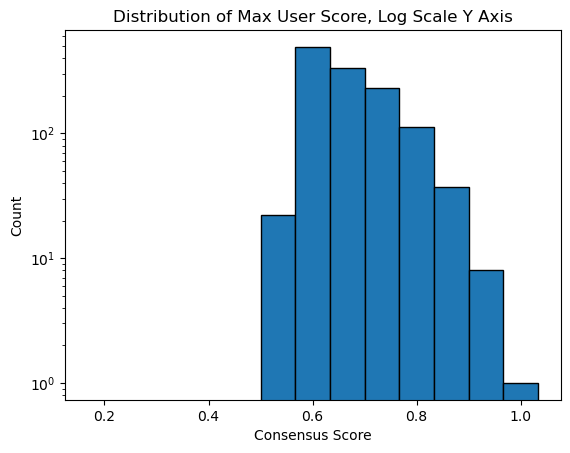

In [120]:
#Histogram of Max User Scores (log y scale)
result_retired_user55['data.agreement'].plot(kind='hist',bins=bin_edges_55,logy=True,edgecolor='black')
plt.xlabel('Consensus Score')
plt.ylabel('Count')
plt.title('Distribution of Max User Score, Log Scale Y Axis')
#plt.xticks(x, rotation=45)
plt.show()

In [121]:
bin_edges_energy_55 = np.histogram_bin_edges(np.log10(result_retired_user55['energy'][:]),bins=13)

In [122]:
H_55, xedges_55, yedges_55 = np.histogram2d(x=result_retired_user55['data.agreement'],y=np.log10(result_retired_user55['energy']),bins=(bin_edges_55,bin_edges_energy_55))

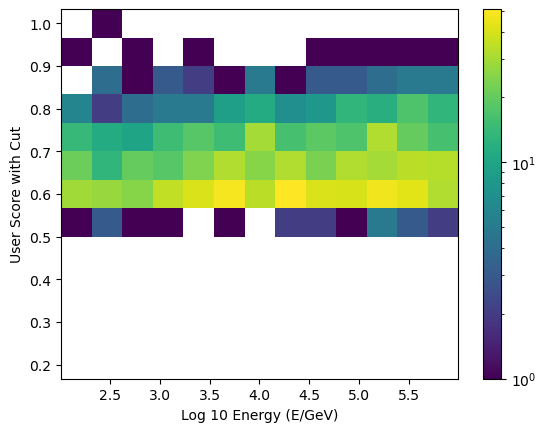

In [124]:
#plt.hist2d(result_retired['data.agreement'],result_retired['energy'],norm=mpl.colors.LogNorm(),bins=[xedges,yedges])
plt.hist2d(np.log10(result_retired_user55['energy']),result_retired_user55['data.agreement'],norm=mpl.colors.LogNorm(),bins=[yedges_55,xedges_55])
plt.colorbar()
plt.xlabel("Log 10 Energy (E/GeV)")
plt.ylabel("User Score with Cut")
#plt.xticks(x,rotation=45)
plt.show()

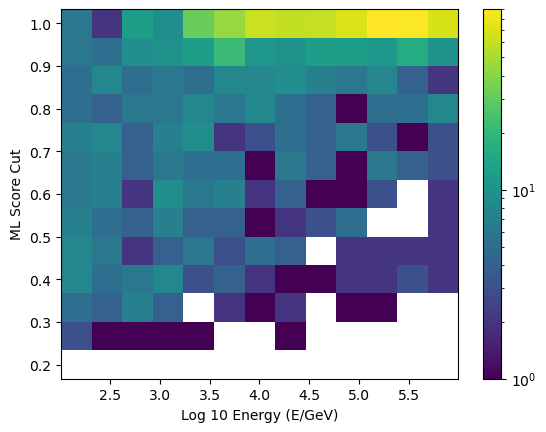

In [125]:
#plt.hist2d(result_retired['data.agreement'],result_retired['energy'],norm=mpl.colors.LogNorm(),bins=[xedges,yedges])
H_55_ml, xedges_55_ml, yedges_55_ml = np.histogram2d(x=result_retired_user55['max_score_val'],y=np.log10(result_retired_user55['energy']),bins=(bin_edges_55,bin_edges_energy_55))
plt.hist2d(np.log10(result_retired_user55['energy']),result_retired_user55['max_score_val'],norm=mpl.colors.LogNorm(),bins=[yedges_55_ml,xedges_55_ml])
plt.colorbar()
plt.xlabel("Log 10 Energy (E/GeV)")
plt.ylabel("ML Score Cut")
#plt.xticks(x,rotation=45)
plt.show()

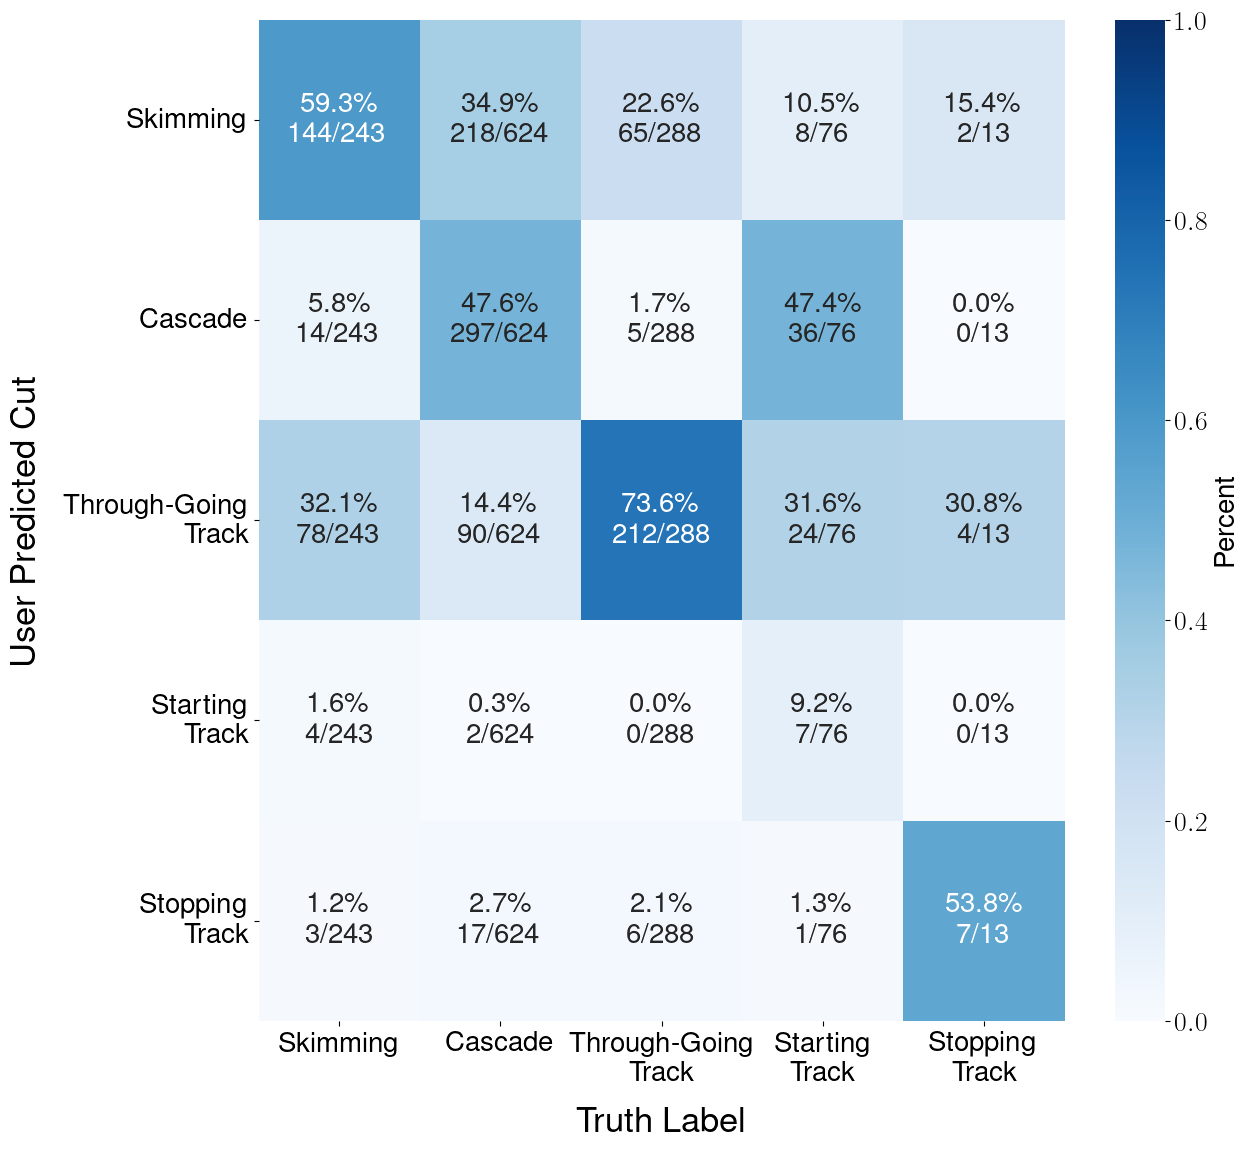

In [233]:
confusion_matrix_retired_55_norm = pd.crosstab(result_retired_user55['data.most_likely'], result_retired_user55['truth_classification'], rownames=['User Predicted'], colnames=['Truth'], margins=False,normalize='columns')
confusion_matrix_retired_55 = pd.crosstab(result_retired_user55['data.most_likely'], result_retired_user55['truth_classification'], rownames=['User Predicted'], colnames=['Truth'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_retired_55_norm, annot=GetUncertaintyLabels(confusion_matrix_retired_55), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Percent'})
plt.ylabel('User Predicted Cut',fontsize=25,labelpad=15)
plt.xlabel('Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("user_retired_cm_cut.png")
plt.show()

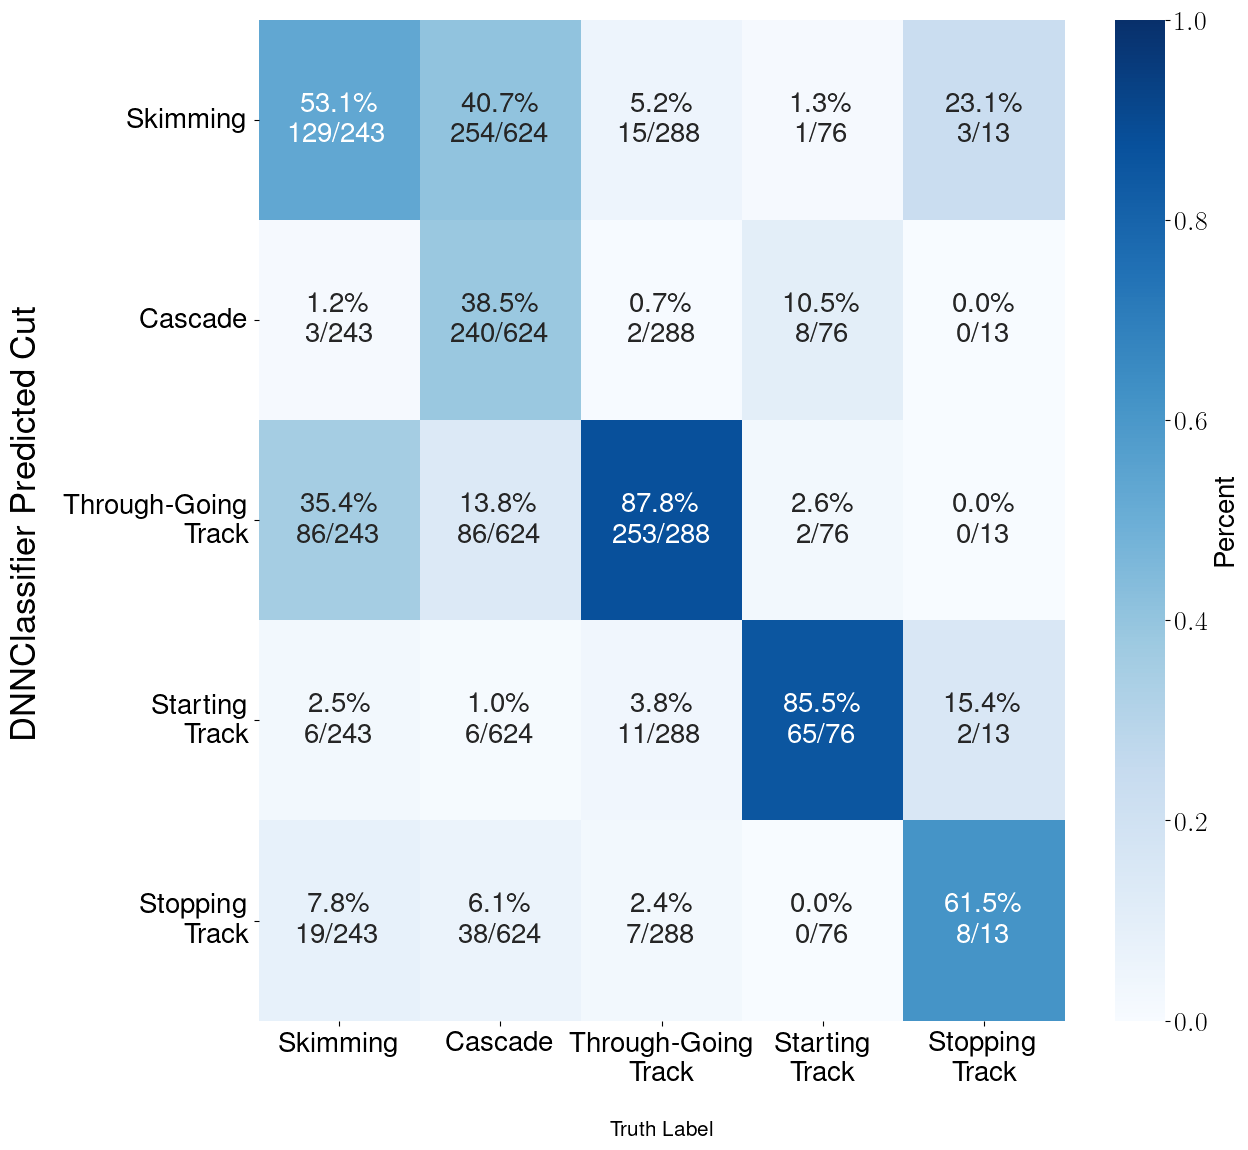

In [236]:
confusion_matrix_retired_ml_55_norm = pd.crosstab(result_retired_user55['idx_max_score'], result_retired_user55['truth_classification'], rownames=['ML Predicted'], colnames=['Truth'], margins=False,normalize='columns')
confusion_matrix_retired_ml_55 = pd.crosstab(result_retired_user55['idx_max_score'], result_retired_user55['truth_classification'], rownames=['ML Predicted'], colnames=['Truth'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_retired_ml_55_norm, annot=GetUncertaintyLabels(confusion_matrix_retired_ml_55), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Percent'})
plt.ylabel('DNNClassifier Predicted Cut',fontsize=25,labelpad=15)
plt.xlabel('Truth Label',fontsize=15,labelpad=25)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("ml_retired_cm_cut.png")
plt.show()

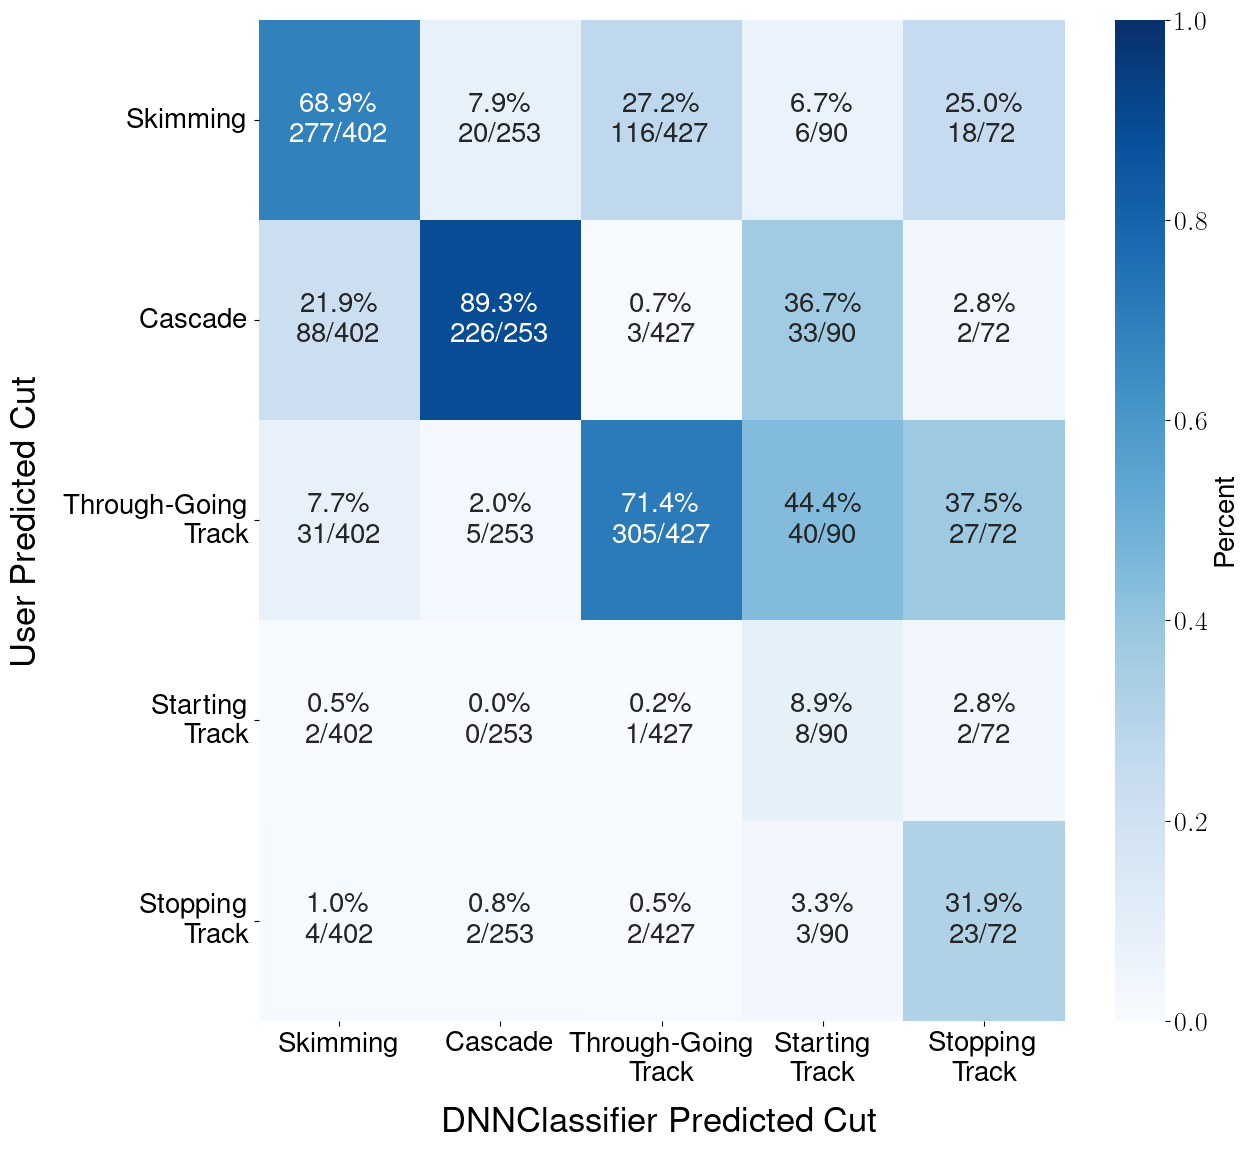

In [252]:
confusion_matrix_user_ml_55_norm = pd.crosstab(result_retired_user55['data.most_likely'], result_retired_user55['idx_max_score'], rownames=['User'], colnames=['ML'], margins=False,normalize='columns')
confusion_matrix_user_ml_55 = pd.crosstab(result_retired_user55['data.most_likely'], result_retired_user55['idx_max_score'], rownames=['User'], colnames=['ML'], margins=False)

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(confusion_matrix_user_ml_55_norm, annot=GetUncertaintyLabels(confusion_matrix_user_ml_55), fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Percent'})
plt.ylabel('User Predicted Cut',fontsize=25,labelpad=15)
plt.xlabel('DNNClassifier Predicted Cut',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="20", va="center")
plt.savefig("ml_user_cm_cut.png")
plt.show()

## Making Event Characterization Plots ##

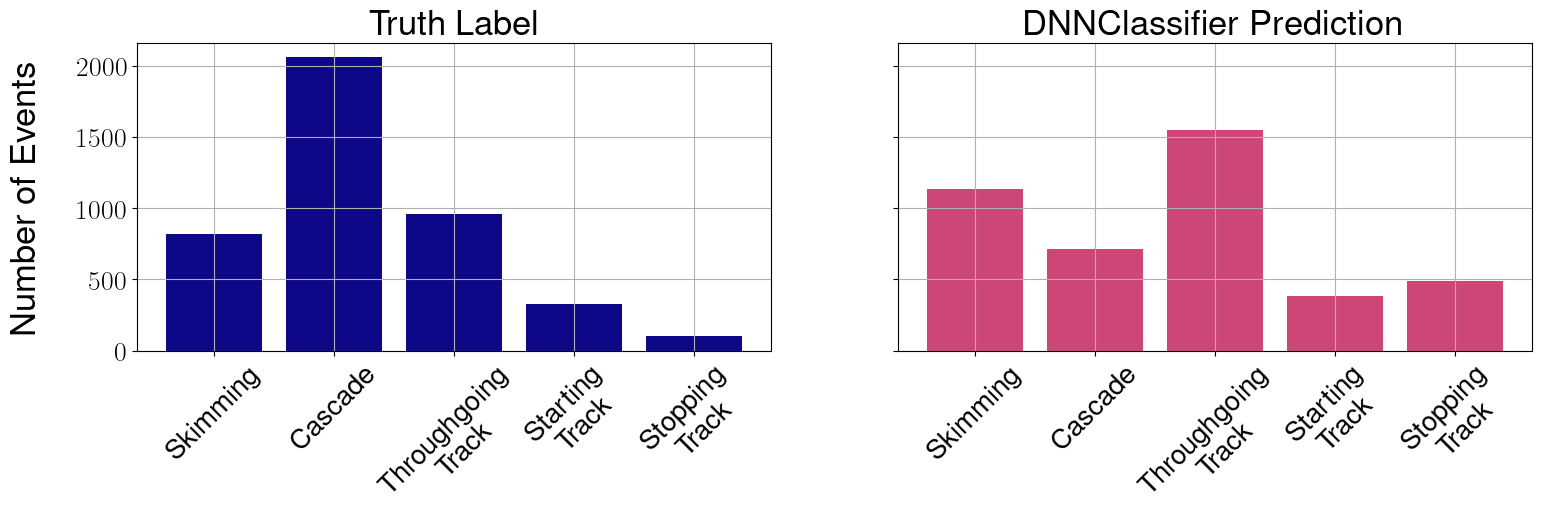

In [159]:
skim_ml = len(result_retired.loc[result_retired['idx_max_score']==0])
cascade_ml = len(result_retired.loc[result_retired['idx_max_score']==1])
tg_track_ml = len(result_retired.loc[result_retired['idx_max_score']==2])
start_track_ml = len(result_retired.loc[result_retired['idx_max_score']==3])
stop_track_ml = len(result_retired.loc[result_retired['idx_max_score']==4])
counts= [skim_ml, cascade_ml, tg_track_ml, start_track_ml, stop_track_ml]

skim_truth = len(result_retired.loc[result_retired['truth_classification']==0])
cascade_truth = len(result_retired.loc[result_retired['truth_classification']==1])
tg_track_truth = len(result_retired.loc[result_retired['truth_classification']==2])
start_track_truth = len(result_retired.loc[result_retired['truth_classification']==3])
stop_track_truth = len(result_retired.loc[result_retired['truth_classification']==4])

counts_truth = [skim_truth,cascade_truth,tg_track_truth,start_track_truth,stop_track_truth]

fig, axss = plt.subplots(1,2,figsize=(18,4),facecolor='white', sharey=True)
axs = np.ravel(axss)
    #labels = [r'log$_{10}$(E [1/GeV])', 'Truth Label', etc...]
lw=3

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size" : 20
})

for idx, ax in enumerate(axs):
    cmap = plt.cm.get_cmap('plasma')
    color = cmap(idx * (1/len(axs))) #change color=color
    #if idx == 0:
        #ax.hist(np.log10(result_retired['energy'][:]), bins = 25, color = cmap(idx * (1/len(axs))),density=False,histtype='step', lw=lw)
        #ax.set_ylabel('Number of Events',fontsize=25,labelpad=10)
        #ax.set_xlabel(r'log$_{10}$(E [GeV])',fontsize=20,labelpad=15)
    if idx == 0:
        ax.bar(x=[0,1, 2,3,4],height=counts_truth,color = cmap(idx * (1/len(axs))),align='center')
        ax.set_title(r'Truth Label',fontsize=25)
        ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0,1,2,3,4]))
        ax.set_ylabel(r'Number of Events',fontsize=25,labelpad=25)
        #ax.set_yticklabels(np.arange(0,2500,250),fontsize=20)
        ax.set_xticklabels(['Skimming', 'Cascade', 'Throughgoing\nTrack', 'Starting\nTrack', 'Stopping\nTrack'],rotation=45,fontsize=20)    
    if idx == 1:
        ax.bar(x=[0,1, 2,3,4],height=counts,color = cmap(idx * (1/len(axs))),align='center')
        ax.set_title(r'DNNClassifier Prediction',fontsize=25)
        ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0,1,2,3,4]))
        ax.set_xticklabels(['Skimming', 'Cascade', 'Throughgoing \nTrack', 'Starting \nTrack', 'Stopping \nTrack'],rotation=45,fontsize=20)
    #if idx == 3:
        #ax.hist(result_retired['max_score_val'][:],bins=5,histtype='step',density=False, color=color, lw=lw)
        #ax.set_xlabel('DNNClassifier Score',fontsize=20,labelpad=15)
    ax.grid(True)

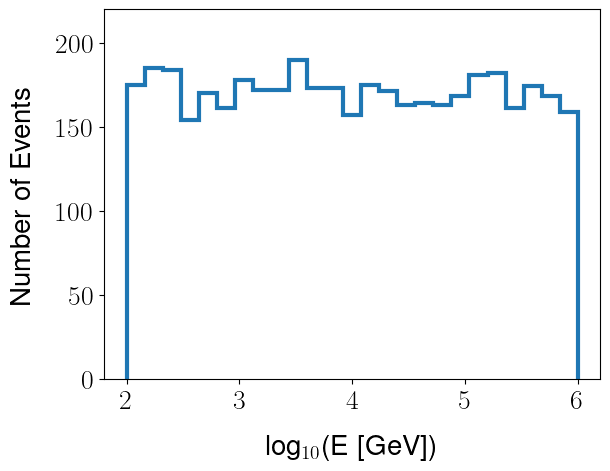

In [178]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size" : 20
})
plt.hist(np.log10(result_retired['energy'][:]), bins = 25,density=False,histtype='step', lw=lw)
plt.ylabel(r'Number of Events',fontsize=20,labelpad=15)
plt.xlabel(r'log$_{10}$(E [GeV])',fontsize=20,labelpad=15)
plt.ylim(0,220)
plt.show()

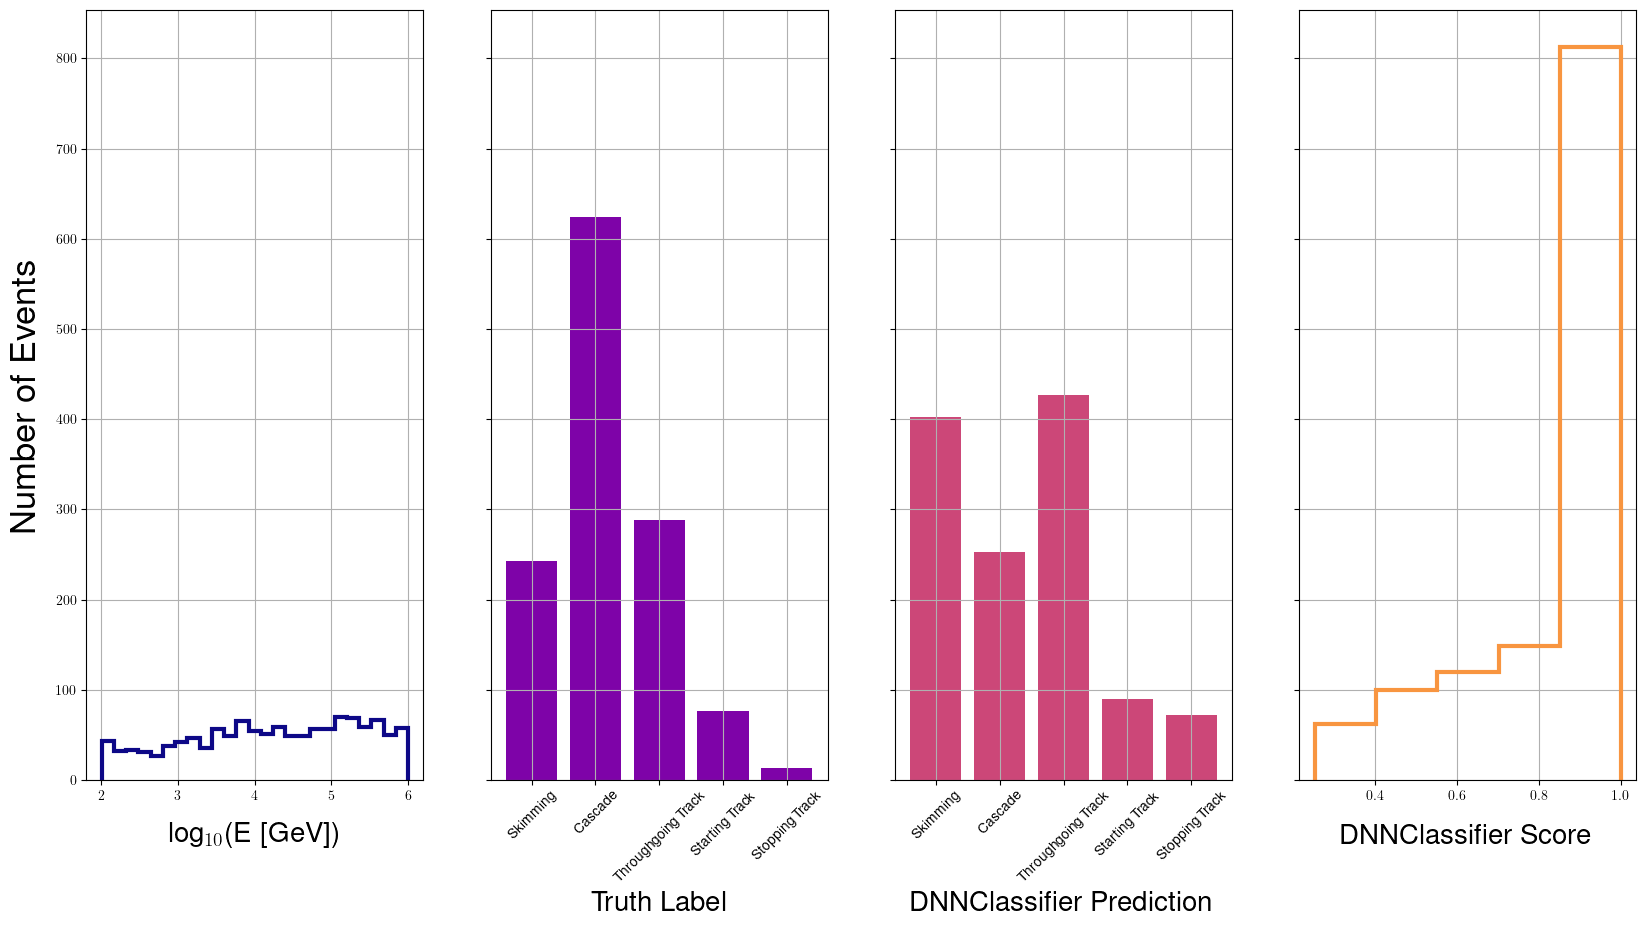

In [146]:
skim_ml = len(result_retired_user55.loc[result_retired_user55['idx_max_score']==0])
cascade_ml = len(result_retired_user55.loc[result_retired_user55['idx_max_score']==1])
tg_track_ml = len(result_retired_user55.loc[result_retired_user55['idx_max_score']==2])
start_track_ml = len(result_retired_user55.loc[result_retired_user55['idx_max_score']==3])
stop_track_ml = len(result_retired_user55.loc[result_retired_user55['idx_max_score']==4])
counts= [skim_ml, cascade_ml, tg_track_ml, start_track_ml, stop_track_ml]

skim_truth = len(result_retired_user55.loc[result_retired_user55['truth_classification']==0])
cascade_truth = len(result_retired_user55.loc[result_retired_user55['truth_classification']==1])
tg_track_truth = len(result_retired_user55.loc[result_retired_user55['truth_classification']==2])
start_track_truth = len(result_retired_user55.loc[result_retired_user55['truth_classification']==3])
stop_track_truth = len(result_retired_user55.loc[result_retired_user55['truth_classification']==4])

counts_truth = [skim_truth,cascade_truth,tg_track_truth,start_track_truth,stop_track_truth]

fig, axss = plt.subplots(1,4,figsize=(20,10),facecolor='white', sharey=True)
axs = np.ravel(axss)
    #labels = [r'log$_{10}$(E [1/GeV])', 'Truth Label', etc...]
lw=3
for idx, ax in enumerate(axs):
    cmap = plt.cm.get_cmap('plasma')
    color = cmap(idx * (1/len(axs))) #change color=color
    if idx == 0:
        ax.hist(np.log10(result_retired_user55['energy'][:]), bins = 25, color = cmap(idx * (1/len(axs))),density=False,histtype='step', lw=lw)
        ax.set_ylabel('Number of Events',fontsize=25,labelpad=10)
        ax.set_xlabel(r'log$_{10}$(E [GeV])',fontsize=20,labelpad=15)
    if idx == 1:
        ax.bar(x=[0,1, 2,3,4],height=counts_truth,color = cmap(idx * (1/len(axs))),align='center')
        ax.set_xlabel('Truth Label',fontsize=20)
        ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0,1,2,3,4]))
        ax.set_xticklabels(['Skimming', 'Cascade', 'Throughgoing Track', 'Starting Track', 'Stopping Track'],rotation=45)    
    if idx == 2:
        ax.bar(x=[0,1, 2,3,4],height=counts,color = cmap(idx * (1/len(axs))),align='center')
        ax.set_xlabel('DNNClassifier Prediction',fontsize=20)
        ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0,1,2,3,4]))
        ax.set_xticklabels(['Skimming', 'Cascade', 'Throughgoing Track', 'Starting Track', 'Stopping Track'],rotation=45)
    if idx == 3:
        ax.hist(result_retired_user55['max_score_val'][:],bins=5,histtype='step',density=False, color=color, lw=lw)
        ax.set_xlabel('DNNClassifier Score',fontsize=20,labelpad=15)
    ax.grid(True)